# Text Analysis

In [7]:
import pandas as pd

df = pd.read_excel('../data/cleaned/daily_sentences_cleaned.xlsx')

## Word Clouds
Word clouds are a way to visually see the most frequent words that appear. For each year, I Produced a unique image for each year

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os

output_folder = '../output/'

# Example: WordCloud for each year
for year, group in df.groupby('Year'):
    text = " ".join(group['cleaned_words'])
    wc = WordCloud(width=800, height=400, background_color='white', stopwords='english').generate(text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {year}")
    #plt.show()

    output_path = os.path.join(output_folder, f"wordcloud_{year}.png")
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close()  # close the figure to free memory

## Word Frequency
Here I count up and find the most frequent words out of the cleaned text. I am looking at the 20 most frequent words

In [36]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

# Choose vectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=50)  # or TfidfVectorizer
X = vectorizer.fit_transform(df['cleaned_words'])

# Convert to DataFrame
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum across all entries
total_freq = word_freq.sum().sort_values(ascending=False)

# Top 20 words
top_20_words = total_freq.head(20).index.tolist()
print("Top 20 words:", top_20_words)

Top 20 words: ['dinner', 'soccer', 'yurie', 'game', 'office', 'ate', 'elise', 'gym', 'watched', 'chicken', 'came', 'food', 'lunch', 'minwoo', 'shopping', 'wfh', 'house', 'work', 'cream', 'ice']


After getting those top 20 words, I want to see across what years they appear

In [ ]:
# Initialize a DataFrame with words as rows, years as columns
years = sorted(df['Year'].unique())
freq_yoy = pd.DataFrame(index=top_20_words, columns=years)

# Fill in the frequencies
for year, group in df.groupby('Year'):
    text = group['cleaned_words'].tolist()
    vectorizer = CountVectorizer(vocabulary=top_20_words)  # only top words
    X = vectorizer.fit_transform(text)
    year_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum()
    
    freq_yoy[year] = year_freq

# Display YoY frequency table
#print(freq_yoy)

A heatmap visualization to better show it

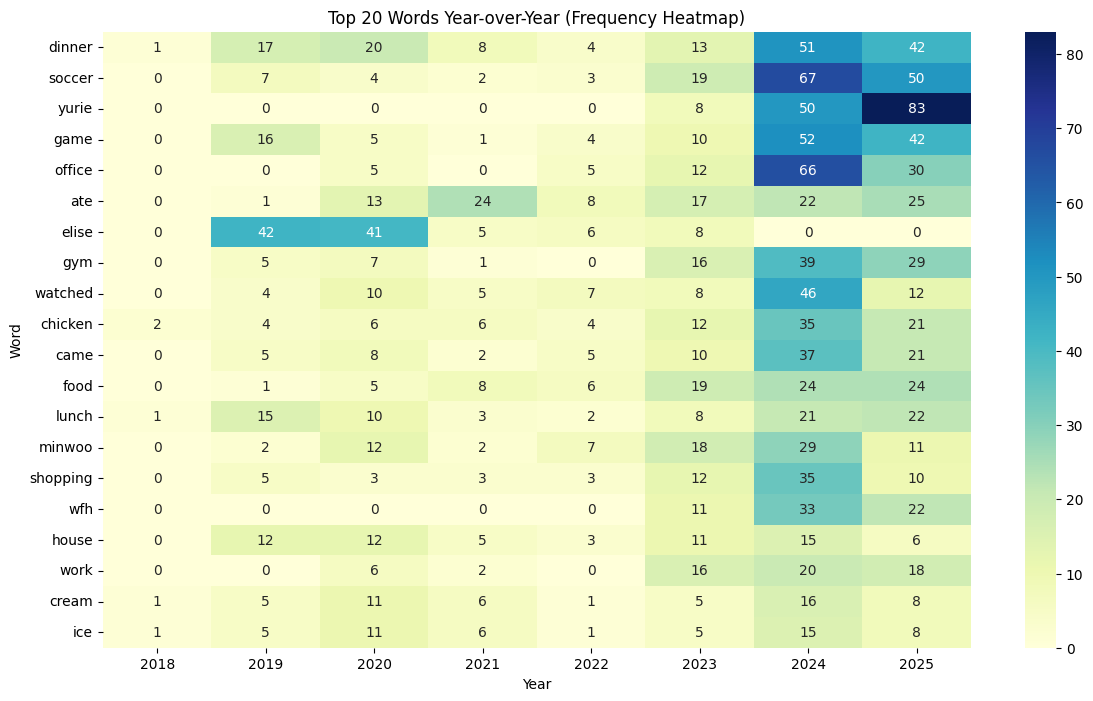

In [44]:
import seaborn as sns

plt.figure(figsize=(14,8))
sns.heatmap(freq_yoy, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Top 20 Words Year-over-Year (Frequency Heatmap)")
plt.ylabel("Word")
plt.xlabel("Year")
plt.show()

As an extra, this calulates the frequency of words per year.

In [46]:
yearly_word_freq = {}

for year, group in df.groupby('Year'):
    # Combine all text entries for that year
    text = group['cleaned_words'].tolist()
    
    # Fit vectorizer on the combined text
    vectorizer = CountVectorizer(stop_words='english', max_features=50)
    X = vectorizer.fit_transform(text)
    
    # Convert to DataFrame
    word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    # Sum across all entries to get total frequency per word for the year
    total_freq = word_freq.sum().sort_values(ascending=False)
    
    yearly_word_freq[year] = total_freq

# Example: print top 20 words for each year
'''
for year, freqs in yearly_word_freq.items():
    print(f"--- {year} ---")
    print(freqs.head(5))
    print()
'''

'\nfor year, freqs in yearly_word_freq.items():\n    print(f"--- {year} ---")\n    print(freqs.head(5))\n    print()\n'

## N-gram analysis (2-3 words phrases)

Instead of looking at each word individually, this aims to look at phrases

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_ngram = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=30)
X_ngram = vectorizer_ngram.fit_transform(df['cleaned_words'])
ngram_freq = pd.DataFrame(X_ngram.toarray(), columns=vectorizer_ngram.get_feature_names_out())
top_ngrams = ngram_freq.sum().sort_values(ascending=False)
top_10_ngrams = top_ngrams.head(10)
print(f"Top 10 n-grams:\n{top_10_ngrams}")

Top 10 n-grams:
ice cream        51
soccer game      31
yurie came       27
brandon casey    20
taco bell        20
chinese food     15
noodle soup      14
men game         13
late night       13
sweet frog       13
dtype: int64


# Sentiment Analysis

In [9]:
from transformers import pipeline

sentiment_pipeline = pipeline('sentiment-analysis')
df['Sentiment'] = df['Sentence'].apply(lambda x: sentiment_pipeline(x)[0])

# Separate label and score
df['sentiment_label'] = df['Sentiment'].apply(lambda x: x['label'])
df['sentiment_score'] = df['Sentiment'].apply(lambda x: x['score'])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Looking and summing only the 'positive' records

In [28]:
# Set threshold for confident positive sentiment
threshold = 0.75

# Create a boolean column: 1 if POSITIVE AND score >= threshold, else 0
df['is_positive_confident'] = df.apply(
    lambda row: 1 if (row['sentiment_label'] == 'POSITIVE' and row['sentiment_score'] >= threshold) else 0,
    axis=1
)

# Now calculate fraction positive over time
daily_sentiment = df.groupby('Date')['is_positive_confident'].mean()
monthly_sentiment = df.groupby('Month')['is_positive_confident'].mean()
yearly_sentiment = df.groupby('Year')['is_positive_confident'].mean()

Visualize the monthly sentiment - across year to year they are about the same. Understandable since most of these are short journal entries that simply describe what I am doing

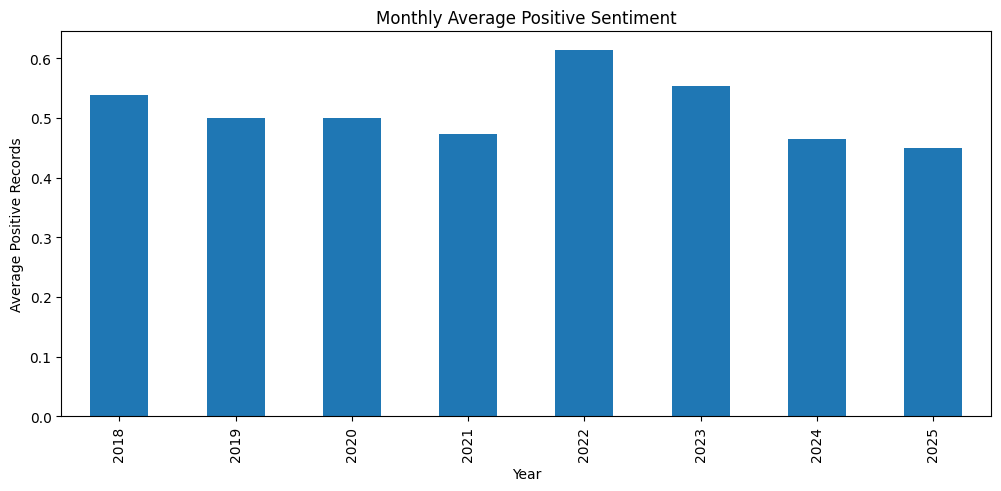

In [29]:
import matplotlib.pyplot as plt

yearly_sentiment.plot(kind='bar', figsize=(12,5))
plt.title("Monthly Average Positive Sentiment")
plt.ylabel("Average Positive Records")
plt.show()

Display the records that the model thinks are for sure negative.
It picked up a sick day, a day where I was bad at golf, and a soccer game that did not go well.

In [25]:
negative_rows = df[df['sentiment_label'] == 'NEGATIVE']
top_negatives = negative_rows.nlargest(3, 'sentiment_score')
print(top_negatives[['Date', 'Sentence', 'sentiment_label', 'sentiment_score']].to_string())

           Date                                                                                                      Sentence sentiment_label  sentiment_score
749  2023-11-21                                                                 Sick day 2, slept all day and didn’t do much.        NEGATIVE         0.999719
1262 2019-12-21  Changed blues car battery, played some more golf and was really bad. Went to watch star wars with the bro’s.        NEGATIVE         0.999708
377  2024-04-22                                                                   Played soccer game and didn’t go very well.        NEGATIVE         0.999604


## Topic Modeling
Method 1 - Latent Dirichlet Allocation (LDA)

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

# Use CountVectorizer for LDA
vectorizer_lda = CountVectorizer(stop_words='english', max_features=1000)
X_lda = vectorizer_lda.fit_transform(df['Sentence'])

lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(X_lda)

# Show top words per topic
terms = vectorizer_lda.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx+1}: ", [terms[i] for i in topic.argsort()[-10:]])

Topic 1:  ['house', 'night', 'shopping', 'lunch', 'played', 'went', 'home', 'dinner', 'elise', 'day']
Topic 2:  ['dinner', 'ate', 'food', 'office', 'game', 'soccer', 'yurie', 'played', 'went', 'got']


Method 2 - Non-Negative Matrix Factorization (NMF)

In [63]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_nmf = TfidfVectorizer(stop_words='english', max_features=1000)
X_nmf = vectorizer_nmf.fit_transform(df['Sentence'])

nmf = NMF(n_components=3, random_state=42)
nmf.fit(X_nmf)

terms = vectorizer_nmf.get_feature_names_out()
#for idx, topic in enumerate(nmf.components_):
#    print(f"Topic {idx+1}: ", [terms[i] for i in topic.argsort()[-10:]])

Visualize the different topics, group 1 is essentially my ex and group 2 is my gf

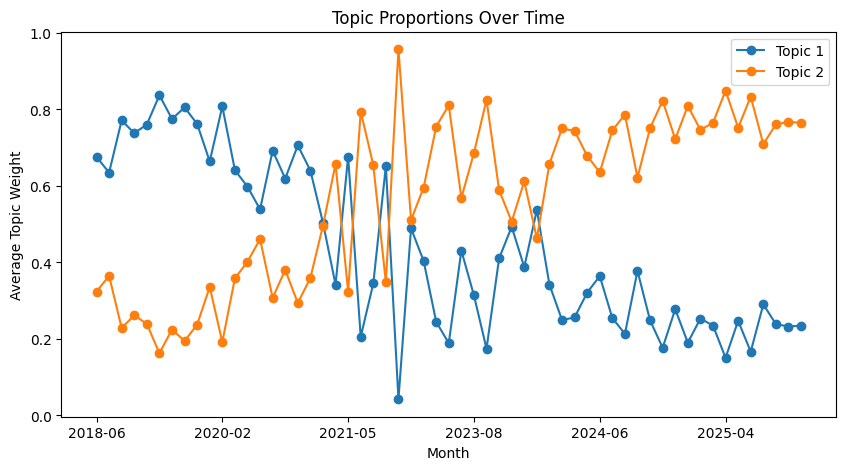

In [ ]:
# Get topic distributions for each entry
topic_distributions = lda.transform(X_lda)
topic_df = pd.DataFrame(topic_distributions, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
topic_df['Month'] = df['Month']

# Average topic proportions by month
topic_trends = topic_df.groupby('Month').mean()
0
# Plot over time
topic_trends.plot(kind='line', figsize=(10,5), marker='o')
plt.title("Topic Proportions Over Time")
plt.ylabel("Average Topic Weight")
plt.show()